In [41]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pickle
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [28]:
with open("../data/train.pkl", "rb") as f:
    train_data = pickle.load(f)

In [29]:
train_data

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
df = pd.DataFrame(train_data, columns = ["Sequence", "Author"])

In [ ]:
df["Author"].value_counts()

Author
0    1630
1     478
3     441
4     236
2     154
Name: count, dtype: int64

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, X, y):
        self.X = [torch.tensor(x, dtype=torch.float32) for x in X]
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["Sequence"], df["Author"], test_size = 0.2, random_state = 42)

In [ ]:
X_train

456     [80.0, 80.0, 80.0, 158.0, 92.0, 92.0, 93.0, 12...
462     [0.0, 47.0, 47.0, 157.0, 28.0, 28.0, 12.0, 0.0...
2216    [-1.0, -1.0, -1.0, 0.0, 12.0, 125.0, 12.0, 12....
2668    [144.0, 144.0, 34.0, 68.0, 20.0, 32.0, 146.0, ...
381     [64.0, 64.0, 92.0, 159.0, 28.0, 47.0, 78.0, 64...
                              ...                        
1638    [-1.0, -1.0, 112.0, 0.0, 0.0, 117.0, 12.0, 12....
1095    [0.0, 82.0, 148.0, 148.0, 132.0, 3.0, 6.0, 8.0...
1130    [-1.0, -1.0, -1.0, 0.0, 5.0, 13.0, 78.0, 12.0,...
1294    [12.0, 12.0, 12.0, 12.0, 47.0, 44.0, 44.0, 44....
860     [-1.0, -1.0, 0.0, 0.0, 0.0, 13.0, 172.0, 92.0,...
Name: Sequence, Length: 2351, dtype: object

In [ ]:
# X_train = X_train.apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())

print(X_train)

456     [80.0, 80.0, 80.0, 158.0, 92.0, 92.0, 93.0, 12...
462     [0.0, 47.0, 47.0, 157.0, 28.0, 28.0, 12.0, 0.0...
2216    [-1.0, -1.0, -1.0, 0.0, 12.0, 125.0, 12.0, 12....
2668    [144.0, 144.0, 34.0, 68.0, 20.0, 32.0, 146.0, ...
381     [64.0, 64.0, 92.0, 159.0, 28.0, 47.0, 78.0, 64...
                              ...                        
1638    [-1.0, -1.0, 112.0, 0.0, 0.0, 117.0, 12.0, 12....
1095    [0.0, 82.0, 148.0, 148.0, 132.0, 3.0, 6.0, 8.0...
1130    [-1.0, -1.0, -1.0, 0.0, 5.0, 13.0, 78.0, 12.0,...
1294    [12.0, 12.0, 12.0, 12.0, 47.0, 44.0, 44.0, 44....
860     [-1.0, -1.0, 0.0, 0.0, 0.0, 13.0, 172.0, 92.0,...
Name: Sequence, Length: 2351, dtype: object


In [ ]:
# X_test = X_test.apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())

In [ ]:
train_dataset = pd.concat([X_train, y_train], axis =1)
v_dataset = pd.concat([X_test, y_test], axis = 1)

In [ ]:
type(v_dataset.iloc[:, 1])

pandas.core.series.Series

In [ ]:
type(train_dataset.iloc[:, 1])

pandas.core.series.Series

In [ ]:
valid_dataset = MusicDataset(v_dataset.iloc[:,0], v_dataset.iloc[:, 1])
train_dataset = MusicDataset(train_dataset.iloc[:,0], train_dataset.iloc[:, 1])

In [ ]:
print(type(train_dataset[10]))
print(train_dataset[10])

<class 'tuple'>
(tensor([  2.,  36.,  68., 116., 148.,   1.,  82.,  50.,  84.,  21.,  92., 136.,
         92.,  14.,  28.,   9., 175.,  60., 108.,  13., 173., 175.,  92.,  92.,
        175.,  13.,  60., 126.,  12.,  12.,  14.,  95.,  13., 175., 126.,  92.,
         12., 126.,  92.,   0., 173.,  13.,  28.,  61.,  14.,  60., 136.,  92.,
         92., 175., 108.,  28.,  61.,   9., 108., 125.,  13., 126.,  92.,  68.,
          2.,  65., 180.,  28.,  12.,  12., 126.,  28.,  95.,  61.,  14.,  13.,
         60.,  93.,  60., 126., 175., 111.,  28., 158., 158.,  92.,  93.,  12.,
         95., 140., 175.,  15., 140.,  14.,  92., 159.,  93., 180.,  12., 126.,
         12.,   1.,  46.,  42.,  95.,  95., 140.,  12.,  12.,  12.,  28.,  12.,
         42.,  42.,  12., 140.,  12.,  12., 126.,  28.,  12.,  28.,  60.,  29.,
         15.,  12.,  12.,   8., 125.,  60.,  28.,  60.,  12.,  60.,  95.,  12.,
         12., 185., 119.,  95.,  95.,  56., 140., 108.,  95.,  92.,  36.,   2.,
         68., 140., 140

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_dim, dropout=0.6)
        self.fc = nn.Linear(hidden_dim, output_dim).float()
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layer_dim, batch_size, self.hidden_dim)
        cell = torch.zeros(self.layer_dim, batch_size, self.hidden_dim)
        return hidden, cell
    
    def forward(self, x ,x_len, hidden):
        x_packed = pack_padded_sequence(x, x_len, batch_first=False, enforce_sorted=False)
        all_outputs, hidden = self.lstm(x_packed, hidden)
        preds, pred_len = pad_packed_sequence(all_outputs, batch_first=False, padding_value=0)
        x = self.fc(hidden[0][-1].float())
        return x, hidden
           
        

In [ ]:
df["Author"].nunique()

5

In [ ]:
hidden_dim = 512
layer_dim = 8
input_dim = 1
out_dim = df["Author"].nunique()
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, out_dim)
model.to(device)


LSTMClassifier(
  (lstm): LSTM(1, 512, num_layers=8, dropout=0.6)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
weights = 1.0 / torch.from_numpy(df["Author"].value_counts().values)
weights = weights / weights.sum()  
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), 0.001)
loss_fun = nn.CrossEntropyLoss(weights.to(device))

In [ ]:


pad = -10000

# Wyrównanie sekwencji w mini batch
def pad_collate(batch, pad_value=pad):
    xx, yy = zip(*batch)
    x_lens = [len(x) if x.dim() > 0 else 0 for x in xx]
    y_lens = [len(y) if y.dim() > 0 else 0 for y in yy]

    xx = [x.unsqueeze(0) if x.dim() == 0 else x for x in xx]
    yy = [y.unsqueeze(0) if y.dim() == 0 else y for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens

In [ ]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn = pad_collate)
train_dataset[10]

(tensor([  2.,  36.,  68., 116., 148.,   1.,  82.,  50.,  84.,  21.,  92., 136.,
          92.,  14.,  28.,   9., 175.,  60., 108.,  13., 173., 175.,  92.,  92.,
         175.,  13.,  60., 126.,  12.,  12.,  14.,  95.,  13., 175., 126.,  92.,
          12., 126.,  92.,   0., 173.,  13.,  28.,  61.,  14.,  60., 136.,  92.,
          92., 175., 108.,  28.,  61.,   9., 108., 125.,  13., 126.,  92.,  68.,
           2.,  65., 180.,  28.,  12.,  12., 126.,  28.,  95.,  61.,  14.,  13.,
          60.,  93.,  60., 126., 175., 111.,  28., 158., 158.,  92.,  93.,  12.,
          95., 140., 175.,  15., 140.,  14.,  92., 159.,  93., 180.,  12., 126.,
          12.,   1.,  46.,  42.,  95.,  95., 140.,  12.,  12.,  12.,  28.,  12.,
          42.,  42.,  12., 140.,  12.,  12., 126.,  28.,  12.,  28.,  60.,  29.,
          15.,  12.,  12.,   8., 125.,  60.,  28.,  60.,  12.,  60.,  95.,  12.,
          12., 185., 119.,  95.,  95.,  56., 140., 108.,  95.,  92.,  36.,   2.,
          68., 140., 140.,  

In [ ]:
first_batch = next(iter(train_loader))
print(len(first_batch))

4


In [ ]:
EPOCHS_NUMBER = 100
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
model.train()
batch_num = 0
for epoch in tqdm_progress:
    train_losses = 0
    for x, targets, x_len, target_len in train_loader:
        x = torch.transpose(x, 0, 1)
        optimizer.zero_grad()
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device).squeeze(1)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
    
        preds, _ = model(x,x_len, (hidden, state)) 
        print(preds)
        preds = preds.squeeze(1)
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        train_losses += loss.item()

    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_losses},

        }
    )

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[-0.0236, -0.0123,  0.0066,  0.0071, -0.0087],
        [-0.0189, -0.0081,  0.0071,  0.0040, -0.0091],
        [-0.0239, -0.0134,  0.0080,  0.0062, -0.0061],
        [-0.0217, -0.0125,  0.0100,  0.0056, -0.0037],
        [-0.0207, -0.0096,  0.0142,  0.0071, -0.0039],
        [-0.0213, -0.0107,  0.0091,  0.0051, -0.0076],
        [-0.0237, -0.0123,  0.0115,  0.0050, -0.0028],
        [-0.0259, -0.0068,  0.0089,  0.0090, -0.0105],
        [-0.0215, -0.0088,  0.0125,  0.0050, -0.0062],
        [-0.0231, -0.0096,  0.0084,  0.0084, -0.0051],
        [-0.0177, -0.0070,  0.0133,  0.0072, -0.0025],
        [-0.0240, -0.0131,  0.0130,  0.0052, -0.0050],
        [-0.0234, -0.0142,  0.0123,  0.0045, -0.0072],
        [-0.0168, -0.0059,  0.0105,  0.0074, -0.0038],
        [-0.0214, -0.0105,  0.0107,  0.0015, -0.0047],
        [-0.0237, -0.0104,  0.0154,  0.0080, -0.0060],
        [-0.0197, -0.0121,  0.0100,  0.0103, -0.0055],
        [-0.0196, -0.0104,  0.0123,  0.0050, -0.0074],
        [-

  1%|          | 1/100 [00:27<46:04, 27.92s/it, Epoch=1, Los in train={112.26833188533783}]

tensor([[-0.0651,  0.1039, -0.7931,  0.2599,  0.3084],
        [-0.1645,  0.0922, -0.9658,  0.4308,  0.4317],
        [-0.5122, -0.0559, -1.1796,  0.9917,  0.5236],
        [-0.4767, -0.0312, -1.1724,  0.9654,  0.4905],
        [-0.5411, -0.0541, -1.4516,  1.1834,  0.5830],
        [ 0.0678,  0.1352, -0.6335,  0.0096,  0.2518],
        [-0.1846,  0.0329, -1.1539,  0.5707,  0.5728],
        [-0.1624,  0.0351, -1.0352,  0.5183,  0.4146],
        [ 0.1335,  0.1636, -0.7080, -0.0534,  0.3170],
        [-0.1593,  0.0706, -0.9238,  0.4032,  0.4732],
        [ 0.0229,  0.0669, -0.9978,  0.2259,  0.5692],
        [-0.3565,  0.0389, -1.1011,  0.7618,  0.4616],
        [-0.3470,  0.0639, -1.1198,  0.7314,  0.4888],
        [-0.0966,  0.0456, -0.8805,  0.3735,  0.3688],
        [-0.0047,  0.0977, -0.8785,  0.2136,  0.3901]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-0.1367,  0.0608, -1.1122,  0.4557,  0.5353],
        [-0.5414, -0.1006, -0.7313,  0.9172,  0.2056],
        [-0.01

  2%|▏         | 2/100 [00:55<45:24, 27.81s/it, Epoch=2, Los in train={107.62895548343658}]

tensor([[-0.2728, -0.2980, -1.0414,  0.8908,  0.4712],
        [-0.4139, -0.4099, -0.9756,  1.0612,  0.4326],
        [-0.1975, -0.2263, -0.8853,  0.6988,  0.4106],
        [-0.2579, -0.2938, -1.1379,  0.8860,  0.5782],
        [ 0.3173,  0.5295, -0.5303, -0.4812,  0.1137],
        [-0.1097, -0.2187, -1.0411,  0.6980,  0.5414],
        [-0.4867, -0.4674, -0.8273,  1.0880,  0.3403],
        [ 0.2059,  0.4443, -0.3378, -0.3784,  0.0356],
        [ 0.3552,  0.5431, -0.6192, -0.5004,  0.1461],
        [ 0.2647,  0.4033, -0.4235, -0.3678,  0.0670],
        [ 0.2532,  0.2601, -0.5561, -0.2017,  0.2091],
        [ 0.3290,  0.3757, -0.6874, -0.2923,  0.2416],
        [-0.2217, -0.3345, -1.0233,  0.8791,  0.5199],
        [-0.4694, -0.5169, -1.0837,  1.2280,  0.4333],
        [-0.0878, -0.2440, -0.9730,  0.6597,  0.5345],
        [ 0.2874,  0.5964, -0.6530, -0.4331,  0.1817],
        [-0.4951, -0.5402, -0.9437,  1.1958,  0.3951],
        [ 0.4086,  0.8549, -0.5801, -0.7601,  0.0436],
        [-

  2%|▏         | 2/100 [01:10<57:37, 35.28s/it, Epoch=2, Los in train={107.62895548343658}]


KeyboardInterrupt: 

In [36]:
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, collate_fn = pad_collate)
valid_dataset[10]

(tensor([ -1.,  -1.,  -1.,  12.,  12.,  12.,  47., 172.,  78.,  64.,  64.,  64.,
         141.,  79.,  76.,  76., 156.,  64., 159.,  92.,  13., 159.,  12., 157.,
          92.,   5.,   5.,   0.,  12., 124., 124., 124., 141., 141.,  12.,  12.,
          78.,  78.,  78.,  64.,  77., 124.,  78.,  78.,  12.,  12.,  69., 152.,
          64.,  64., 159.,  28.,  13.,  13., 159.,  12.,  78.,  78.,  47.,  78.,
          12., 145., 145.,  69.,  69., 159.,  28., 172.,  78.,  64.,  64.,  64.,
          12.,  15.,  76., 154., 156.,  64.,  64.,  64.]),
 tensor(0))

In [44]:
labels_train, labels_val = torch.tensor([], device=device), torch.tensor([], device=device)
predicted_train, predicted_val = torch.tensor([], device=device), torch.tensor([], device=device)
model.eval()
with torch.no_grad():
    for x, targets, x_len, target_len in train_loader:
        x = torch.transpose(x, 0, 1)
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device).squeeze(1)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
        predicts_train, _ = model(x,x_len, (hidden, state)) 
        predicts_train = predicts_train.squeeze(1)
        predicts_train_argmax = torch.argmax(predicts_train, dim=1)
        labels_train = torch.cat((labels_train, targets))
        predicted_train = torch.cat((predicted_train, predicts_train_argmax))
    for x, targets, x_len, target_len in valid_loader:
        x = torch.transpose(x, 0, 1)
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device).squeeze(1)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
        predicts_val, _ = model(x,x_len, (hidden, state)) 
        predicts_val = predicts_val.squeeze(1)
        predicts_val_argmax = torch.argmax(predicts_val, dim=1)
        labels_val = torch.cat((labels_val, targets))
        predicted_val = torch.cat((predicted_val, predicts_val_argmax))

In [45]:
print(labels_train.shape)


torch.Size([2351])


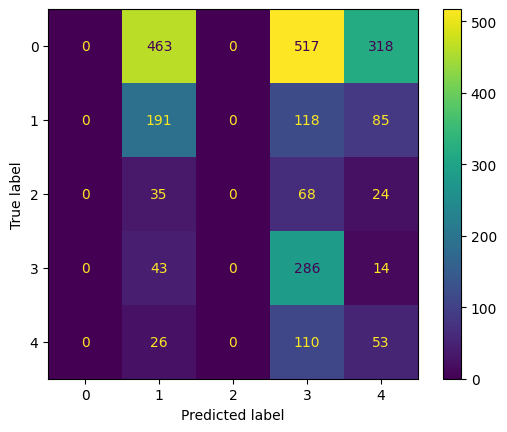

In [47]:
confusion_matrix_train = confusion_matrix(labels_train.cpu() , predicted_train.cpu())
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()